For learning purpose I am implementing word2vec using tf

In [1]:
import numpy as np
import tensorflow as tf

from nltk import word_tokenize
from keras.utils import to_categorical

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
corpus_raw= 'He is the king. The king is royal. She is the royal queen'

corpus_raw=corpus_raw.lower()

to get unique words for vocabulary

In [3]:
words = [word for word in word_tokenize(corpus_raw) if word != '.'] #ignoring DOT

In [4]:
words = set(words)

vocab_size = len(words)

word2int = {o:i for i,o in enumerate(words)};
int2word = {i:o for i,o in enumerate(words)};

In [5]:
sentences =[sentence.split() for sentence in corpus_raw.split('.')]

In [6]:
sentences

[['he', 'is', 'the', 'king'],
 ['the', 'king', 'is', 'royal'],
 ['she', 'is', 'the', 'royal', 'queen']]

This is to get bi-grams for training

In [7]:
data=[]

WIN_LEN =2;

for sentence in sentences :
    for word_idx, word in enumerate(sentence):
        for nb_word in sentence[max(0,word_idx-WIN_LEN) : min(word_idx
                    +WIN_LEN,len(sentence))+1]:
            if nb_word != word:
                data.append([word,nb_word])
        

In [8]:
data[0:6]

[['he', 'is'],
 ['he', 'the'],
 ['is', 'he'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'he']]

In [9]:
x_train = np.array([to_categorical(word2int[a[0]],vocab_size) for a in data])
y_train = np.array([to_categorical(word2int[a[1]],vocab_size) for a in data])

In [10]:
x_train[0:6]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [11]:
y_train[0:6]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [12]:
x_train.shape,y_train.shape

((34, 7), (34, 7))

Writing tensorflow model to train the data

In [13]:
x=tf.placeholder(tf.float32,shape=(None,vocab_size),name='input_word')
y=tf.placeholder(tf.float32,shape=(None,vocab_size),name='pred_word')

In [14]:
x[0].shape

TensorShape([Dimension(7)])

In [15]:
EMB_DIM = 5; # This variable changes based on our vocab_size
#This is we are giving to the next following layer because the output of 
#this layer is where we capture embeddings
# Output = x*W1+b1

W1=tf.Variable(tf.random_normal([vocab_size,EMB_DIM]),name='W1')
b1=tf.Variable(tf.random_normal([EMB_DIM]),name='b1')

hidden_layer = tf.add(tf.matmul(x,W1),b1)

In [16]:
W1,b1,hidden_layer

(<tf.Variable 'W1:0' shape=(7, 5) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(5,) dtype=float32_ref>,
 <tf.Tensor 'Add:0' shape=(?, 5) dtype=float32>)

The following layer is for predictions output/target layer

In [17]:
W2=tf.Variable(tf.random_normal([EMB_DIM,vocab_size]),name='W2')
b2=tf.Variable(tf.random_normal([vocab_size]),name='b2')

prediction_layer = tf.nn.softmax(tf.add(tf.matmul(hidden_layer,W2),b2))

In [18]:
W2,b2,prediction_layer

(<tf.Variable 'W2:0' shape=(5, 7) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(7,) dtype=float32_ref>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

Let's train

In [19]:
sess=tf.Session()

init=tf.global_variables_initializer()

sess.run(init)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction_layer,labels=y)

model = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
iters = 10000;

for i in range(iters):
    sess.run(model,feed_dict={x:x_train,y:y_train})
    if i%1000 ==0 :
        print('loss : ',sess.run(loss,feed_dict={x:x_train,y:y_train}))

loss :  [1.6689411 1.9423704 1.9277214 2.120633  2.1204474 1.8962407 1.947509
 2.085531  1.5721763 2.02001   2.085531  1.947509  2.02001   1.5721763
 2.0272338 2.120633  2.1204474 2.0243533 2.0755103 2.0789943 1.8163263
 1.9642167 2.1202397 2.120633  2.0243533 1.8997399 1.947509  1.9997978
 1.7859854 2.0789943 1.942912  1.5421512 2.149963  2.1553357]
loss :  [1.6157395 1.6163065 1.9125249 2.1315145 2.13151   2.1650352 1.1660149
 2.1652753 1.6162401 1.615845  2.1652753 1.1660149 1.615845  1.6162401
 2.1157358 2.1315145 2.13151   1.3512425 2.164024  1.1711426 1.6158632
 1.6162493 2.1315145 2.1315145 1.3512425 2.1651595 1.1660149 2.165123
 2.1652598 1.1711426 2.1571198 2.1640146 1.16586   2.1653147]
loss :  [1.615851  1.6161157 1.9121633 2.1315277 2.131525  2.1652405 1.1656892
 2.1653562 1.616073  1.6159099 2.1653562 1.1656892 1.6159099 1.616073
 2.1158485 2.1315277 2.131525  1.3512403 2.1646028 1.1687679 1.6159085
 1.6160868 2.1315277 2.1315277 1.3512403 2.1653085 1.1656892 2.1652884
 2.

W1 contains our vectors that represent our words

In [20]:
print(sess.run(W1+b1))

[[ 4.482476   -0.75052404 -0.6933675   1.292055   -1.4003232 ]
 [ 0.71176565 -1.5925647   0.75685596  2.5247107  -2.8285625 ]
 [ 3.1941679   0.9376117  -0.6940783  -0.83478236 -1.2904923 ]
 [ 3.34155    -0.6041374  -1.4217522   0.46607158  0.11367685]
 [ 2.9614196  -0.5742509  -1.6295215   0.34522247 -1.6055583 ]
 [ 1.5724167   0.7099254  -2.3266797   1.0125198  -2.0110402 ]
 [ 5.14285     0.8616059   0.39767027  1.3481035  -0.61935145]]


I am just curious to see if these vectors are orthogonal to each other

In [21]:
for i in range(0,5):
    for j in range(i+1,5):
        print(np.dot(sess.run(W1+b1)[i],sess.run(W1+b1)[j]))

11.083918
14.823854
16.860641
17.529686
1.7976284
3.1196206
7.202064
10.558066
11.835638
12.537818


No they aren't

In [22]:
vectors = sess.run(W1+b1)

print(vectors[word2int['king']])

[ 4.482476   -0.75052404 -0.6933675   1.292055   -1.4003232 ]


In [23]:
vectors

array([[ 4.482476  , -0.75052404, -0.6933675 ,  1.292055  , -1.4003232 ],
       [ 0.71176565, -1.5925647 ,  0.75685596,  2.5247107 , -2.8285625 ],
       [ 3.1941679 ,  0.9376117 , -0.6940783 , -0.83478236, -1.2904923 ],
       [ 3.34155   , -0.6041374 , -1.4217522 ,  0.46607158,  0.11367685],
       [ 2.9614196 , -0.5742509 , -1.6295215 ,  0.34522247, -1.6055583 ],
       [ 1.5724167 ,  0.7099254 , -2.3266797 ,  1.0125198 , -2.0110402 ],
       [ 5.14285   ,  0.8616059 ,  0.39767027,  1.3481035 , -0.61935145]],
      dtype=float32)

In [24]:
int2word[np.argmax(x_train[-1])]

'queen'

In [25]:
vectors[word2int['queen']]

array([ 5.14285   ,  0.8616059 ,  0.39767027,  1.3481035 , -0.61935145],
      dtype=float32)

In [26]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [27]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

king 0.76039666
is 0.16597266
he 0.2252261
she 0.95272195
royal -0.894619
the -0.8210183
queen -0.11043813


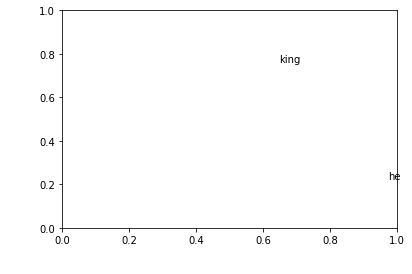

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()